## Technical Exercise for Data Scientist Candidates

##### Author: Wenli Zhang
##### Date: Aug 2021

## Content

1. [Import libraries](#libraries)
1. [Question List](#Question_List)


## 1. Import libraries

<a id='libraries'></a>

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from scipy.sparse import csr_matrix

import nltk
from nltk.corpus import stopwords

from textblob import TextBlob
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA


# Reports
import plotly
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import plotly.express as px
#import plotly.figure_factory as ff
import plotly.io as pio
#pio.renderers.default = "svg" # for plotly report to show as image in github

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 2. Question List

<a id='Question_List'></a>


1. [Rank top 3 Breweries which produce the strongest beers?](#Q1)
1. [Which year did beers enjoy the highest ratings?](#Q2)
1. [Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?](#Q3)
1. [If you were to recommend 3 beers to your friends based on this data which ones will you recommend?](#Q4)
1. [Which Beer style seems to be the favorite based on reviews written by users?](#Q5)
1. [How does written review compare to overall review score for the beer styles?](#Q6)
1. [How do find similar beer drinkers by using written reviews only? ](#Q7)

In [2]:
dfbeer=pd.read_csv('BeerDataScienceProject_small.csv',encoding = "ISO-8859-1")
dfbeer.head()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206


In [3]:
dfbeer[['beer_name','review_appearance','review_overall']].iplot(kind='box', dimensions=(700, 500), 
   title='Overall Beer Rating between 1998-2012',xTitle='Year',yTitle='Beer Rating (scale of 1-5)')

### Key information after data inspection:
#### total record count: 528870
#### beer_style: 104 
#### user: 22800 
#### beer_name: 18339

In [4]:
# get year from utcfromtimestamp
dfbeer['review_year'] = dfbeer.apply(lambda row: datetime.utcfromtimestamp(row.review_time).strftime("%Y"), axis=1)
dfbeer.head()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,review_year
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1234817823,2009
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3.0,stcules,3.0,"Dark red color, light beige foam, average. In ...",1235915097,2009
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3.0,stcules,3.0,"Almost totally black. Beige foam, quite compac...",1235916604,2009
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3.0,"Golden yellow color. White, compact foam, quit...",1234725145,2009
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4.0,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1293735206,2010


In [5]:
#check null value
dfbeer.isnull().sum()

beer_ABV              169
beer_beerId             0
beer_brewerId           0
beer_name               0
beer_style              0
review_appearance       0
review_palette          0
review_overall          0
review_taste            0
review_profileName      0
review_aroma            0
review_text             0
review_time             0
review_year             0
dtype: int64

In [6]:
# Since null counts for review_profileName and review_text are in small percentage, and both are needed for questions asked, so simply drop rows involved
dfbeer = dfbeer[dfbeer['review_profileName'].notna() & dfbeer['review_text'].notna()]
dfbeer.shape

(2795, 14)

In [7]:
# There are multiple entries by same user for same beer name, keep only the most recent entry
dfbeer_dup=dfbeer[dfbeer.groupby(['beer_style','beer_name'])['review_time'].transform('count') > 1]
dfbeer_dup.shape

(2587, 14)

In [8]:
# Sort data by review_time descending; keep the first in each unique'review_profileName' + 'beer_name'
dfbeer = dfbeer.sort_values('review_time', ascending=False)
dfbeer = dfbeer.drop_duplicates(subset= ['review_profileName','beer_name'], keep='first')
dfbeer.shape

(2783, 14)

### 1. Rank top 3 Breweries which produce the strongest beers?
<a id='Q1'></a>

In [9]:
dfbeer.groupby(['beer_brewerId'])['beer_ABV'].mean().nlargest(3)

beer_brewerId
2724     7.643243
20658    7.245000
7314     7.100000
Name: beer_ABV, dtype: float64

#### <font color='green'>Top 3 Breweries: 6513, 736, 24215 </font>

### 2. Which year did beers enjoy the highest ratings?
<a id='Q2'></a>

#### Amoung all the variables, review_overall is the best to indicate 'rating'

In [10]:
dfbeer.groupby(['review_year'])['review_overall'].mean().nlargest(1)

review_year
2012    3.833333
Name: review_overall, dtype: float64

#### <font color='green'>Year 2000 has the highest beer rating of 4.209677 on average </font>

In [11]:
dfbeerT=pd.crosstab(dfbeer.beer_style,dfbeer.review_year,values=dfbeer.review_overall, aggfunc='mean')
dfbeerT.head()

review_year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
beer_style,,,,,,,,,,,,
Altbier,NaN,NaN,NaN,4.0,4.000000,NaN,4.0,3.600000,3.87500,3.857143,4.000000,NaN
American Adjunct Lager,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.833333,3.50000,3.718750,3.750000,NaN
American Amber / Red Ale,NaN,NaN,4.0,3.5,3.833333,3.5,4.0,4.000000,3.84375,3.755556,3.794872,4.0
American Amber / Red Lager,NaN,1.5,NaN,NaN,NaN,3.5,3.0,4.500000,NaN,2.500000,2.000000,NaN
American Barleywine,NaN,NaN,NaN,4.0,NaN,NaN,5.0,4.000000,3.50000,3.000000,4.000000,NaN


#### Graphical representation confirming the result

In [26]:
dfbeerT.iplot(kind='box', dimensions=(700, 500), 
   title='Overall Beer Rating between 1998-2012',xTitle='Year',yTitle='Beer Rating (scale of 1-5)', annotations=[{'text':'Winner!','fontsize':20,'fontcolor':'red','x':'0.17','y':'2.5', 'xref':'paper','arrowhead':5, 'textangle':-1,'ay':70,'ax':-7,'arrowcolor':'red'}])

### 3. Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?
<a id='Q3'></a>

#### Inspect data

In [13]:
dfbeer_corr = dfbeer[[ 'review_appearance', 'review_palette','review_taste', 'review_aroma', 'review_overall']]
dfbeer_corr.describe()

,review_appearance,review_palette,review_taste,review_aroma,review_overall
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000
mean,3.561983,3.376931,3.461552,3.474308,3.598096
std,0.741973,0.844932,0.796263,0.869528,0.848778
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000,3.000000
50%,4.000000,3.500000,3.500000,3.500000,4.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000


##### Plot correlation coefficients with hestmap. Tried both spearman correlation and pearson correlation. Results are very similar.

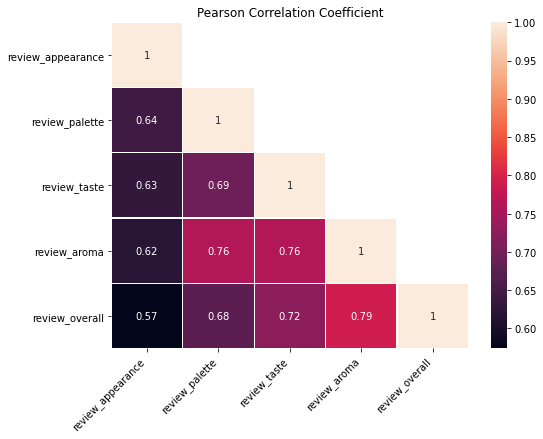

In [14]:
dfbeer_corrM = dfbeer_corr.corr(method='spearman')
umask = np.zeros_like(dfbeer_corrM, dtype=np.bool_)
umask[np.triu_indices_from(umask, k=1)] = True
plt.figure(figsize=(8, 6))
sns.heatmap(dfbeer_corrM, mask=umask, annot=True, linewidths=.3)
tick_marks = np.arange(len(dfbeer_corr.columns))
plt.xticks( tick_marks+0.5,rotation=45,ha='right')
plt.title("Pearson Correlation Coefficient")
plt.show()

#### <font color='green'>Aroma rating has the largest correlation (0.78) with user’s Overall rating. The second is Taste (0.69)</font>

### 4. If you were to recommend 3 beers to your friends based on this data which ones will you recommend?
<a id='Q4'></a>

#### review_overall is the best variable to use for this recommendation. Check what are the unique values in this dataset

In [15]:
dfbeer["review_overall"].unique()

array([4.5, 4. , 3.5, 2. , 5. , 3. , 1. , 2.5, 1.5])

#### Check the review_overall rating distribution using histogram

In [25]:
dfbeer["review_overall"].iplot(kind="histogram", bins=(20),xanchor="left", xrange=[0,5.95],theme="white", title="Beer Overall Rating",xTitle='Rating (Scale of 0-5)', yTitle='Number of Reviews')
fig.show("notebook_connected")

#### About 26.8% of the users gave rating 4.5 or above

In [17]:
len(dfbeer.query('review_overall >= 4.5' ))/len(dfbeer)

0.1976284584980237

In [18]:
#### Create two dataframes since we care both mean rating and number of reviews for each beer

In [19]:
dfbeer_review_count =dfbeer[['beer_name','review_overall']].groupby(['beer_name'])['review_overall'].agg([ 'count'])
dfbeer_review_count.head()

,count
beer_name,
'Pooya Porter,2
10 Blocks South,1
15th Anniversary,2
2001 - A Stout Odyssey,1
Ackerman's Imperial Double Stout (Indiana Replicale 2011),1


In [20]:
dfbeer_review_rating =dfbeer[['beer_name','review_overall']].groupby(['beer_name'])['review_overall'].agg([ 'mean'])
dfbeer_review_rating.head()

,mean
beer_name,
'Pooya Porter,4.25
10 Blocks South,3.50
15th Anniversary,4.00
2001 - A Stout Odyssey,3.00
Ackerman's Imperial Double Stout (Indiana Replicale 2011),4.00


In [21]:
#### Merge the two datasets so each beer_name has both mean rating and total review counts

In [22]:
dfbeer_count_rating=pd.merge(dfbeer_review_count, dfbeer_review_rating, on="beer_name")
dfbeer_count_rating=dfbeer_count_rating.reset_index()
dfbeer_count_rating.head()

,beer_name,count,mean
0,'Pooya Porter,2,4.25
1,10 Blocks South,1,3.50
2,15th Anniversary,2,4.00
3,2001 - A Stout Odyssey,1,3.00
4,Ackerman's Imperial Double Stout (Indiana Repl...,1,4.00


#### Plot the data

In [23]:
fig=px.scatter(dfbeer_count_rating,  x="mean", y="count", 
            hover_name="beer_name",labels={"mean":'Mean Rating',"count":'Number of Reviews'},
           log_x=False, size_max=55, range_y=[0,3000], range_x=[1, 5],title='Beer Rating vs Counts')
fig.show("notebook_connected")